# Max-P Regionalization

**Authors:** **[Sergio Rey](https://github.com/sjsrey),** **[Xin Feng](https://github.com/xf37),** **[James Gaboardi](https://github.com/jGaboardi)**    


The `max-p` problem involves the clustering of a set of geographic areas into the maximum number of homogeneous regions such that the value of a spatially extensive regional attribute is above a predefined threshold value. The spatially extensive attribute can be specified to ensure that each region contains sufficient population size, or a minimum number of enumeration units. The number of regions $p$ is endogenous to the problem and is useful for regionalization problems where the analyst does not require a fixed number of regions a-priori.

Originally formulated as a mixed-integer problem in [Duque, Anselin, Rey (2012)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9787.2011.00743.x), `max-p` is an [NP-hard problem](https://en.wikipedia.org/wiki/NP-hardness) and exact solutions are only feasible for small problem sizes. As such, a number of heuristic solution approaches have been suggested. PySAL implements the heuristic approach described in
[Wei, Rey, and Knaap (2020)](https://www.tandfonline.com/doi/full/10.1080/13658816.2020.1759806).

In [1]:
%load_ext watermark
%watermark

Last updated: 2021-07-15T18:10:26.830526-04:00

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.19.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
from spopt.region import MaxPHeuristic as MaxP
import matplotlib.pyplot as plt

import geopandas
import libpysal
import matplotlib
import numpy
import spopt
import warnings

plt.rcParams["figure.figsize"] = [12, 8]
warnings.filterwarnings("ignore")

RANDOM_SEED = 123456

%config InlineBackend.figure_format = "retina"
%watermark -w
%watermark -iv

Watermark: 2.1.0

matplotlib: 3.3.3
spopt     : 0.1.2
libpysal  : 4.3.0
geopandas : 0.9.0
numpy     : 1.19.5
json      : 2.0.9



## Mexican State Regional Income Clustering

To illustrate `maxp` we utilize data on regional incomes for Mexican states over the period 1940-2000, originally used in [Rey and Sastré-Gutiérrez (2010)](https://www.tandfonline.com/doi/full/10.1080/17421772.2010.493955?casa_token=r6iIZaEKaywAAAAA%3ARxjQkEOcxQ5gffa1EGyd2rByA6w0uVxg5cU3v4VaSmx2u89Nr3oSe2f_n63CV20Ysrjs07U47m98). 

We can first explore the data by plotting the per capital gross regional domestic product (in constant USD 2000 dollars) for each year in the sample, using a quintile classification. Here we will define a function for creating subplots useful in visual comparisons, which also can solve Max-P instances and will be used again later).

In [3]:
def subplotter(gdf, incrs, W, threshold=5, top_n=2, seed=RANDOM_SEED):
    """Helper plotting function, also solves MaxP instances if desired."""
    rows, cols = incrs.shape
    if rows > cols:
        figsize, wspace = (15, 20), -.5
    else:
        figsize, wspace = (20, 15), 1
    f, axs = plt.subplots(rows, cols, figsize=figsize)
    for i in range(rows):
        for j in range(cols):
            year, _ax = incrs[i, j], axs[i, j]
            if not year:
                # plot country geographies
                _attr = "Mexico"
                gdf.plot(ax=_ax, ec="grey", fc="white")
            else:
                _attr = "PCGDP%s" % year
                if not W:
                    # plot country geographies by attributes
                    plt_kws = dict(scheme="Quantiles", cmap="GnBu", ec="grey")
                    gdf.plot(column=_attr, ax=_ax, legend=True, **plt_kws)
                else:
                    # solve a MaxP instance and plot regions
                    numpy.random.seed(seed)
                    maxp_args = gdf, W, _attr, "count", threshold
                    model = MaxP(*maxp_args, top_n=top_n)
                    model.solve()
                    label = year+"labels_"
                    gdf[label] = model.labels_
                    gdf.plot(column=label, ax=_ax, cmap="tab20")
            _ax.set_title(_attr)
            _ax.set_axis_off()
            _ax.set_aspect("equal")
    plt.subplots_adjust(wspace=wspace, hspace=-0.65)
    plt.tight_layout()

In [4]:
pth = libpysal.examples.get_path("mexicojoin.shp")
mexico = geopandas.read_file(pth)
mxgdp_years = [str(x) for x in range(1940, 2010, 10)]
mxgdp_years = numpy.array([None]+mxgdp_years)

### Regional incomes for Mexican states over the period 1940-2000

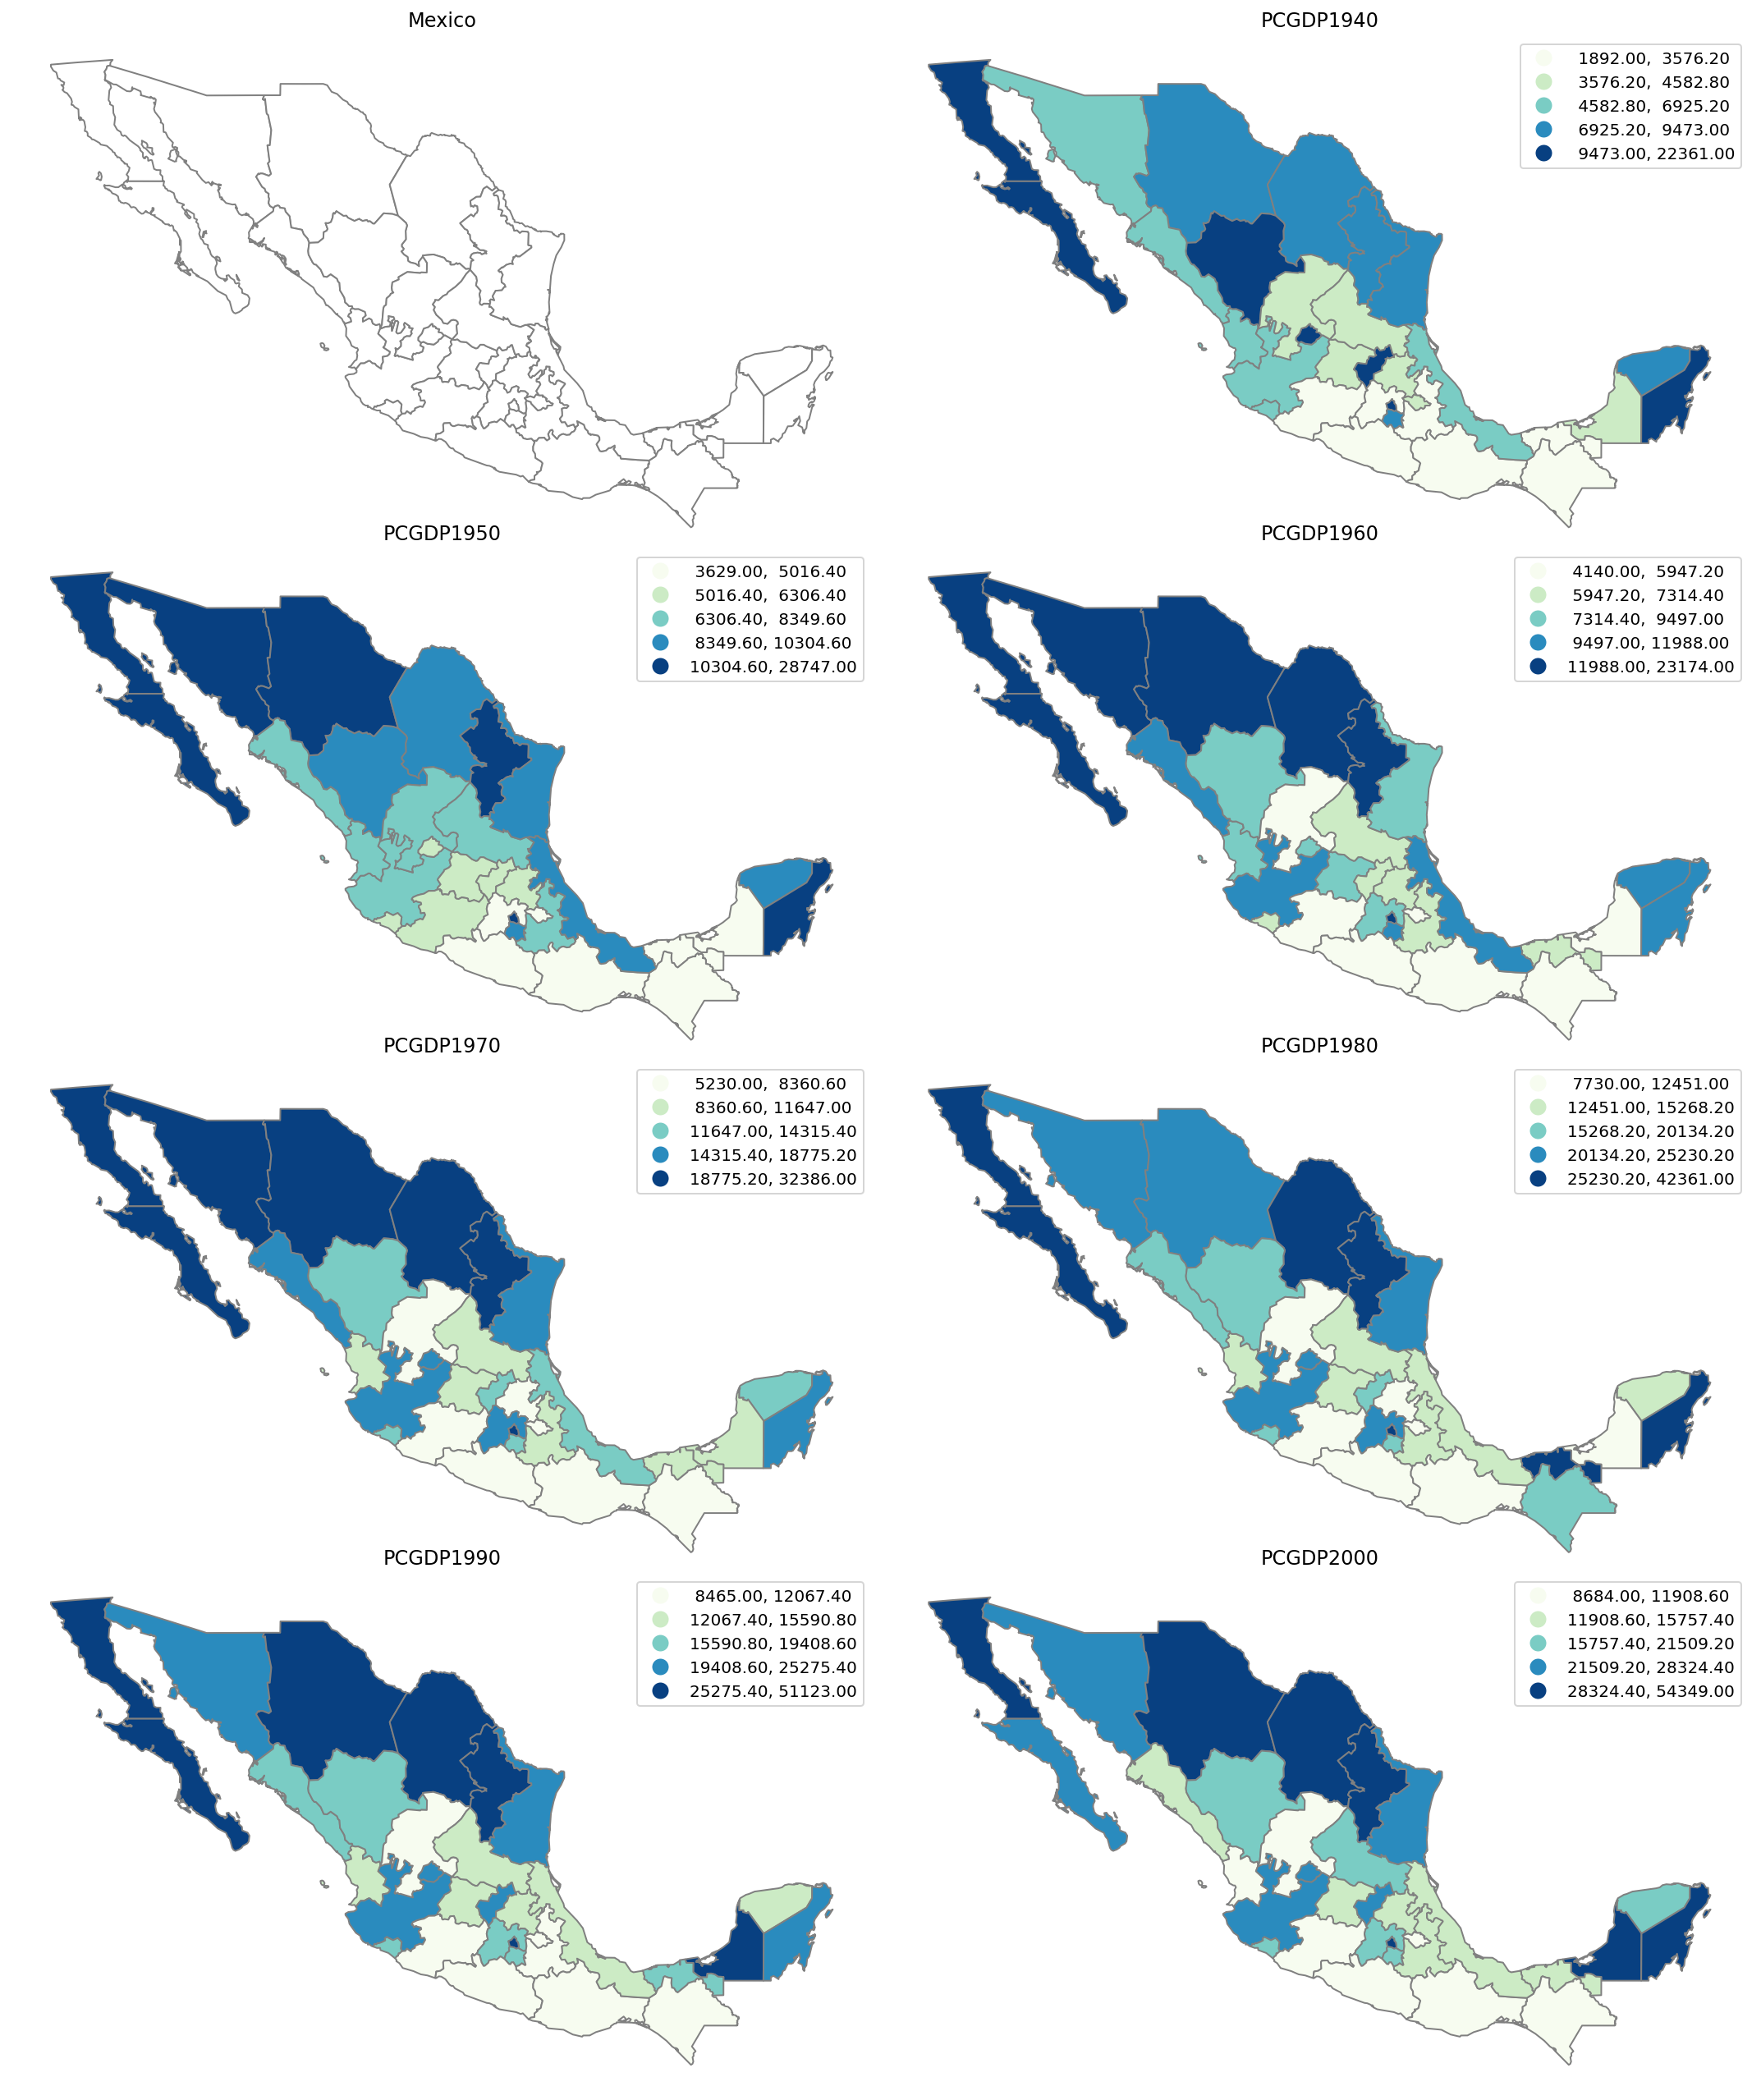

In [5]:
subplotter(mexico, mxgdp_years.reshape(4,2), None)

In general terms, the north-south divide in incomes is present in each of the 7 decades. There is some variation in states moving across quintiles however, and this is true at both the bottom and top of the state income distribution.

To develop a holistic view of the Mexican space economy over this timespan, we can try to form a set of spatially connected regions that maximizes the internal socieconomic levels of the states belonging to each region.

## Pooled Regionalization

To develop our holistic view, we can treat the six cross-sections as a multidimensional array and seek to 
cluster 32 Mexican states into the maximum number of regions such that each region as at least 6 = 32 // 5 states and homogeneity in per capita gross regional product over 1940-2000 is maximized.

We first define the variables in the dataframe that will be used to measure regional homogeneity:

In [6]:
attrs_name = [f"PCGDP{year}" for year in mxgdp_years[1:]]
attrs_name

['PCGDP1940',
 'PCGDP1950',
 'PCGDP1960',
 'PCGDP1970',
 'PCGDP1980',
 'PCGDP1990',
 'PCGDP2000']

Next, we specify a number of parameters that will serve as input to the `max-p` model.

A [spatial weights object](https://pysal.org/libpysal/tutorial.html) expresses the spatial connectivity of the states:

In [7]:
w = libpysal.weights.Queen.from_dataframe(mexico)

The remaining arguments are the minimum number of states each region must have (`threshold`):

In [8]:
threshold = 6

and the number of the top candidate regions to consider when assigning enclaves (`top_n`):

In [9]:
top_n = 2

We create the attribute `count` which will serve as the threshold attribute which we add to the dataframe:

In [10]:
mexico["count"] = 1
threshold_name = "count"

The model can then be instantiated and solved:

In [11]:
numpy.random.seed(RANDOM_SEED)
model = MaxP(mexico, w, attrs_name, threshold_name, threshold, top_n)
model.solve()

In [12]:
mexico["maxp_new"] = model.labels_

In [13]:
mexico[["maxp_new", "AREA"]].groupby(by="maxp_new").count()

,AREA
maxp_new,
1,6
2,7
3,6
4,7
5,6


In [14]:
model.p

5

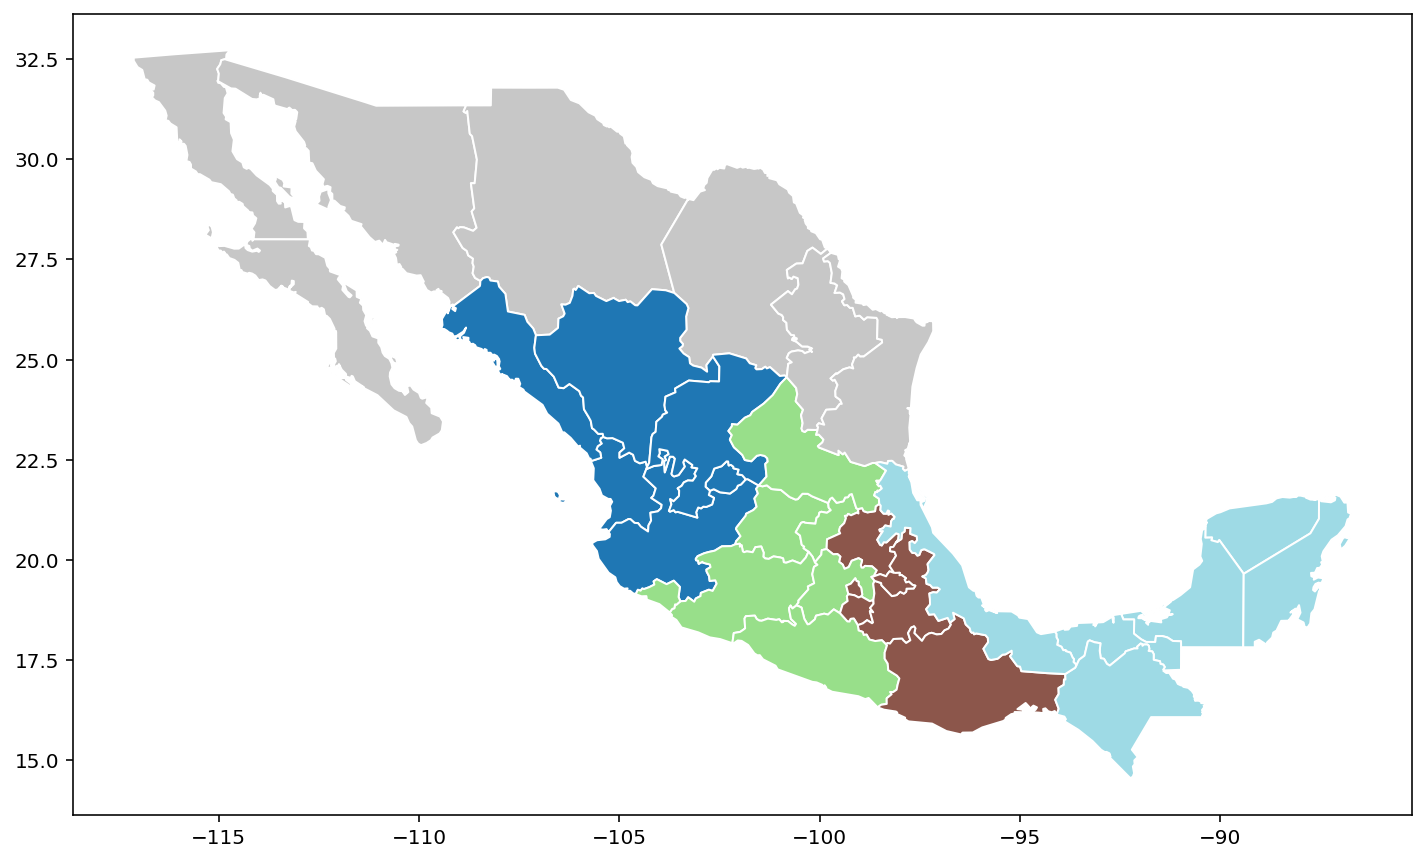

In [15]:
mexico.plot(column="maxp_new", cmap="tab20",  edgecolor="w");

The model solution results in five regions, three of which have six states, and two with seven states each. Each region is a [spatially connected component](https://en.wikipedia.org/wiki/Connected_space), as required by the `max-p` problem.

## Change threshold to a minimum of 3 states per region

In [16]:
numpy.random.seed(RANDOM_SEED)
threshold = 3
model = MaxP(mexico, w, attrs_name, threshold_name, threshold, top_n)
model.solve()

In [17]:
mexico["maxp_3"] = model.labels_
mexico[["maxp_3","AREA"]].groupby(by="maxp_3").count()

,AREA
maxp_3,
1,3
2,3
3,4
4,3
5,3
6,3
7,4
8,3
9,3


In [18]:
model.p

10

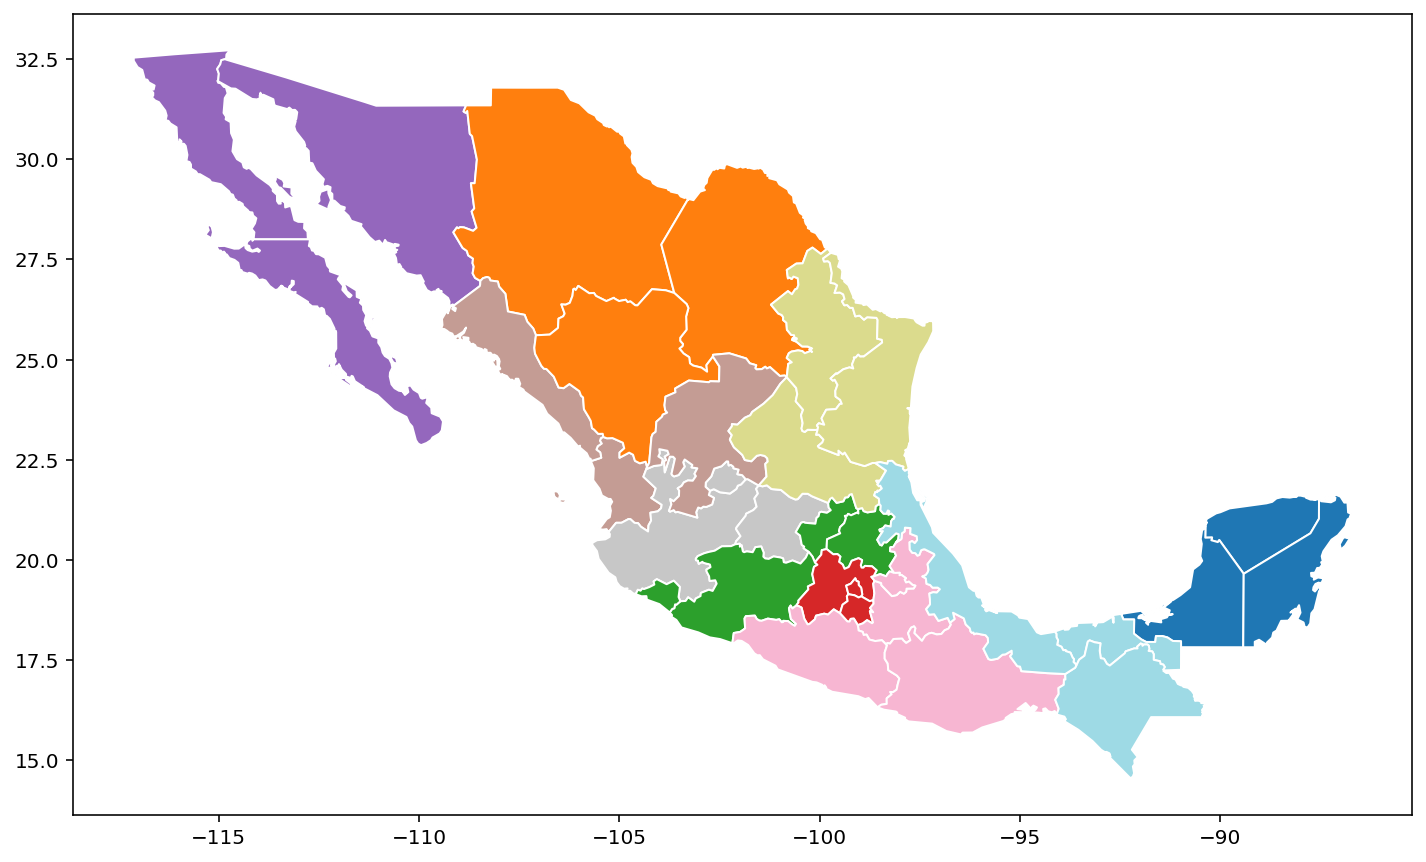

In [19]:
mexico.plot(column="maxp_3", cmap="tab20", edgecolor="w");

## Year-by-Year Regionalization while Varying Parameters

#### Vary minimum in-region threshold (5, 10, 15); hold enclave assignment constant (2)

**5 states**

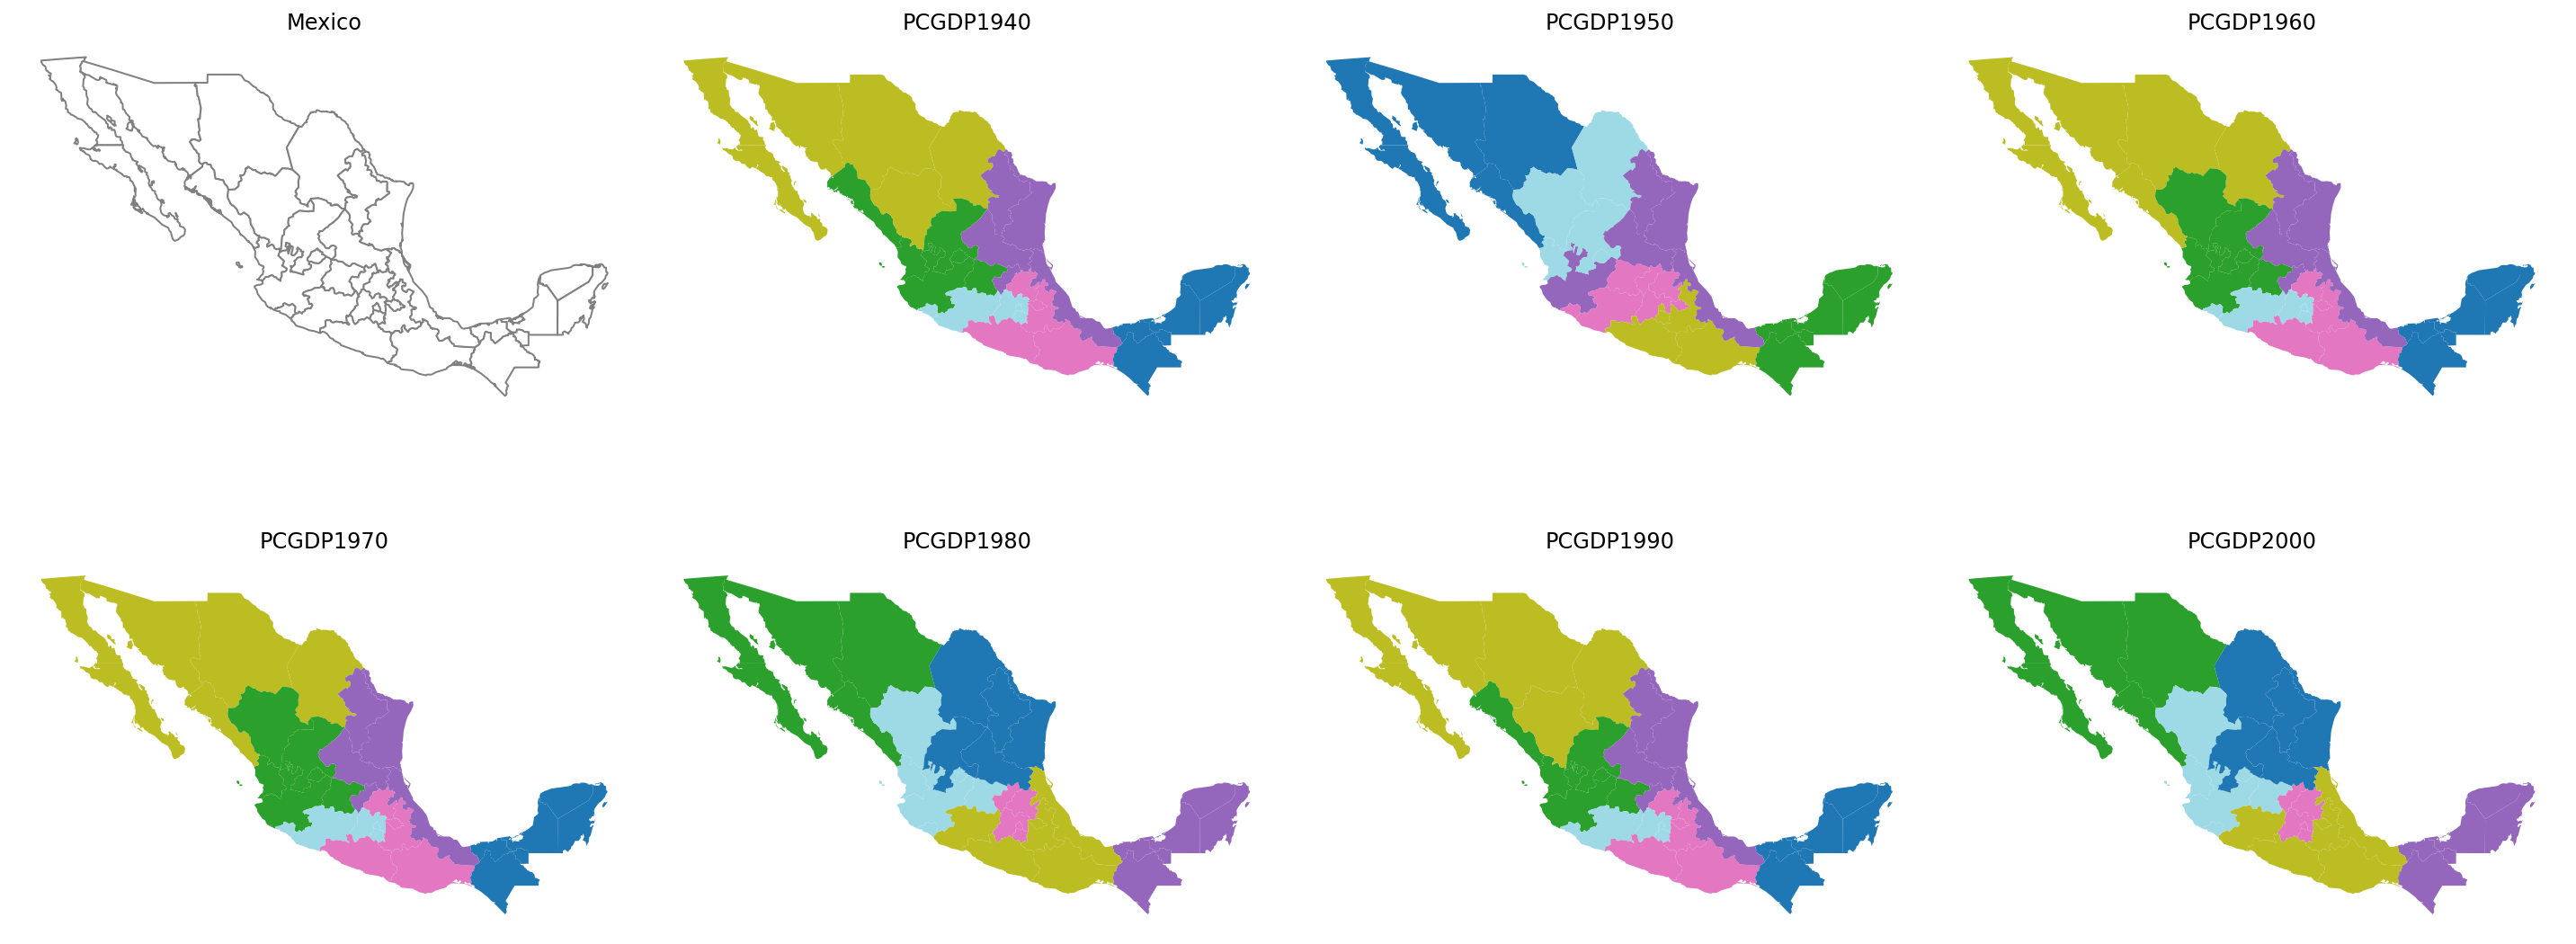

In [20]:
subplotter(mexico, mxgdp_years.reshape(2,4), w, threshold=5, top_n=2)

**10 states**

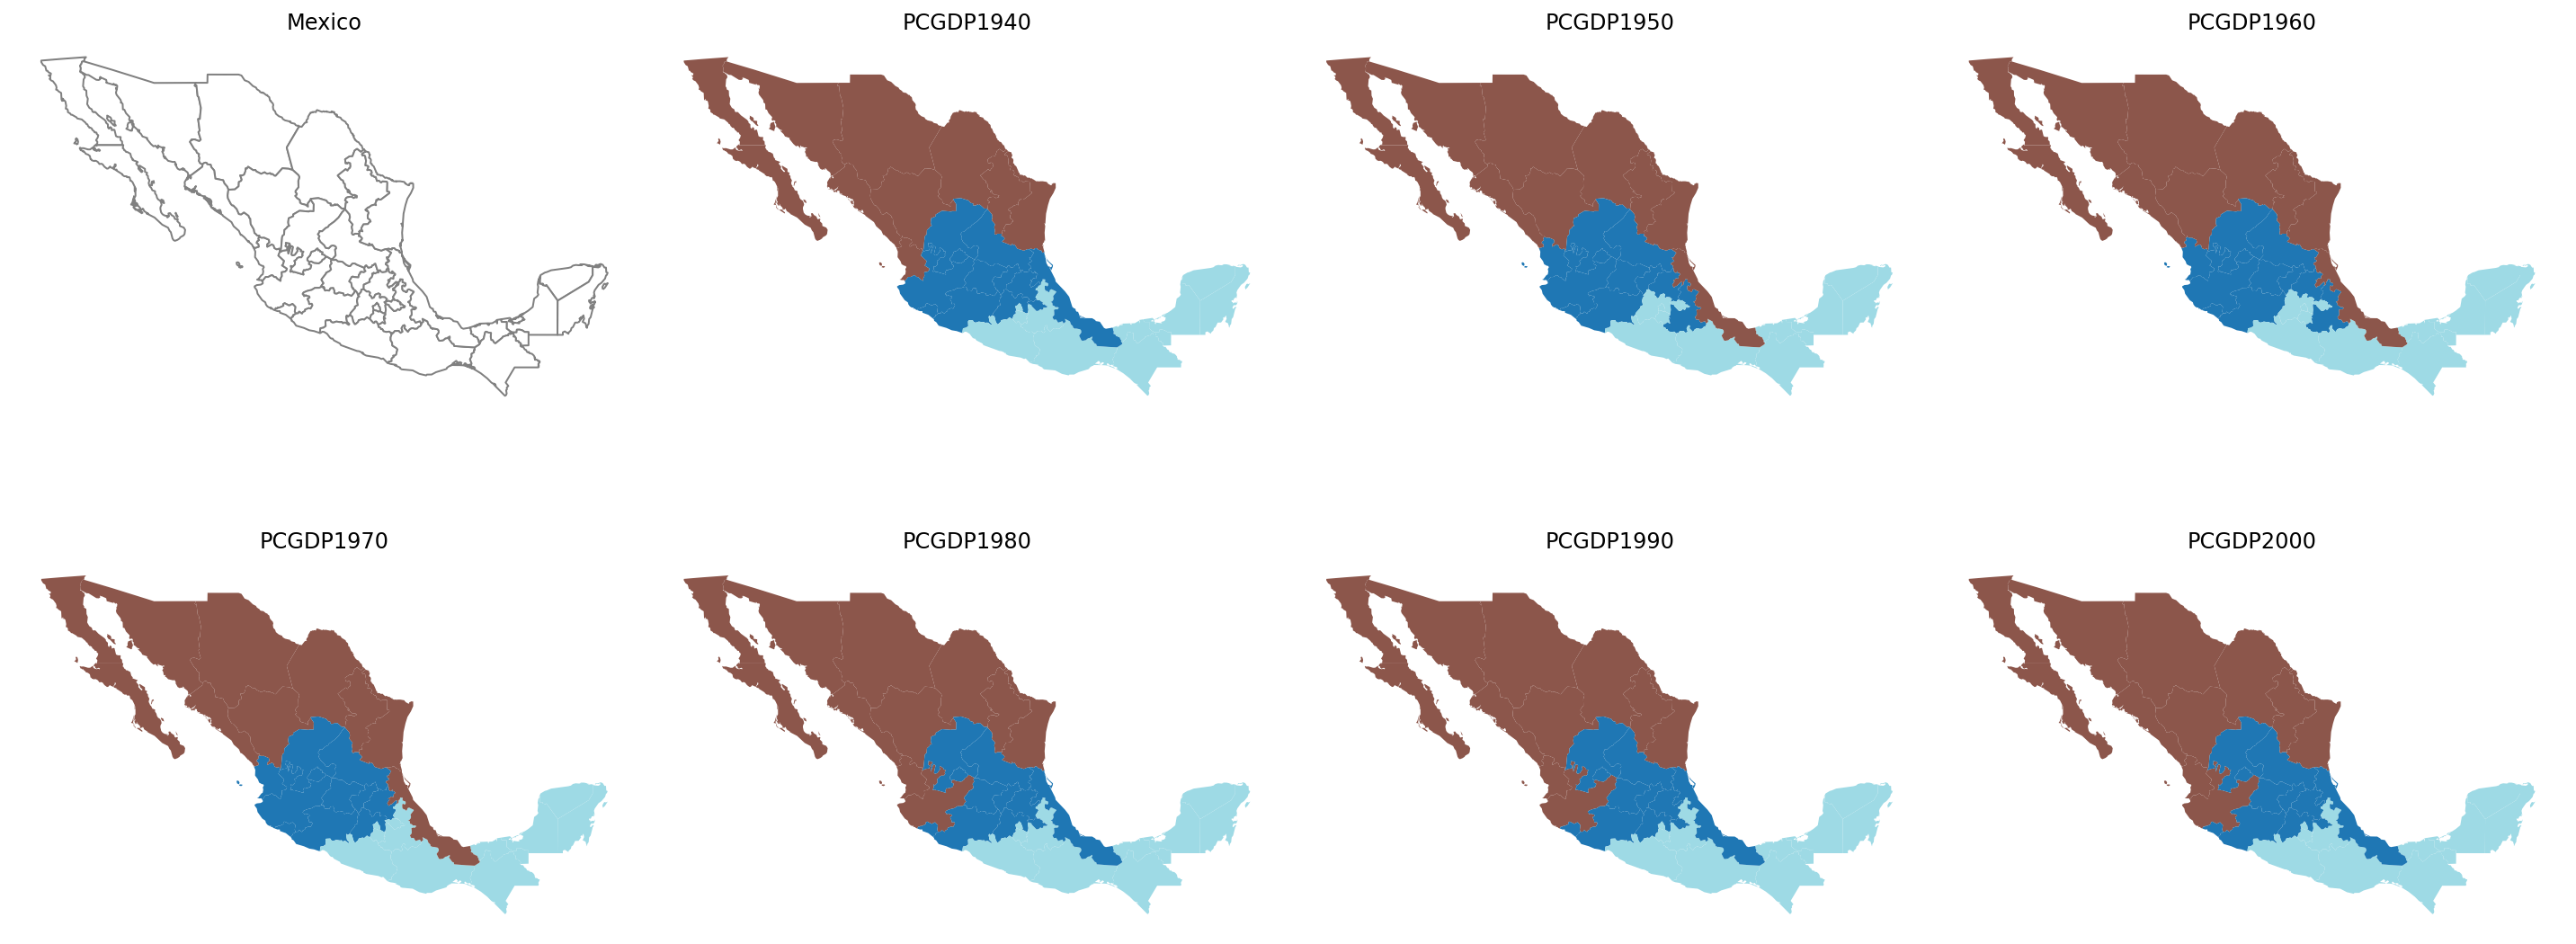

In [21]:
subplotter(mexico, mxgdp_years.reshape(2,4), w, threshold=10, top_n=2)

**15 states**

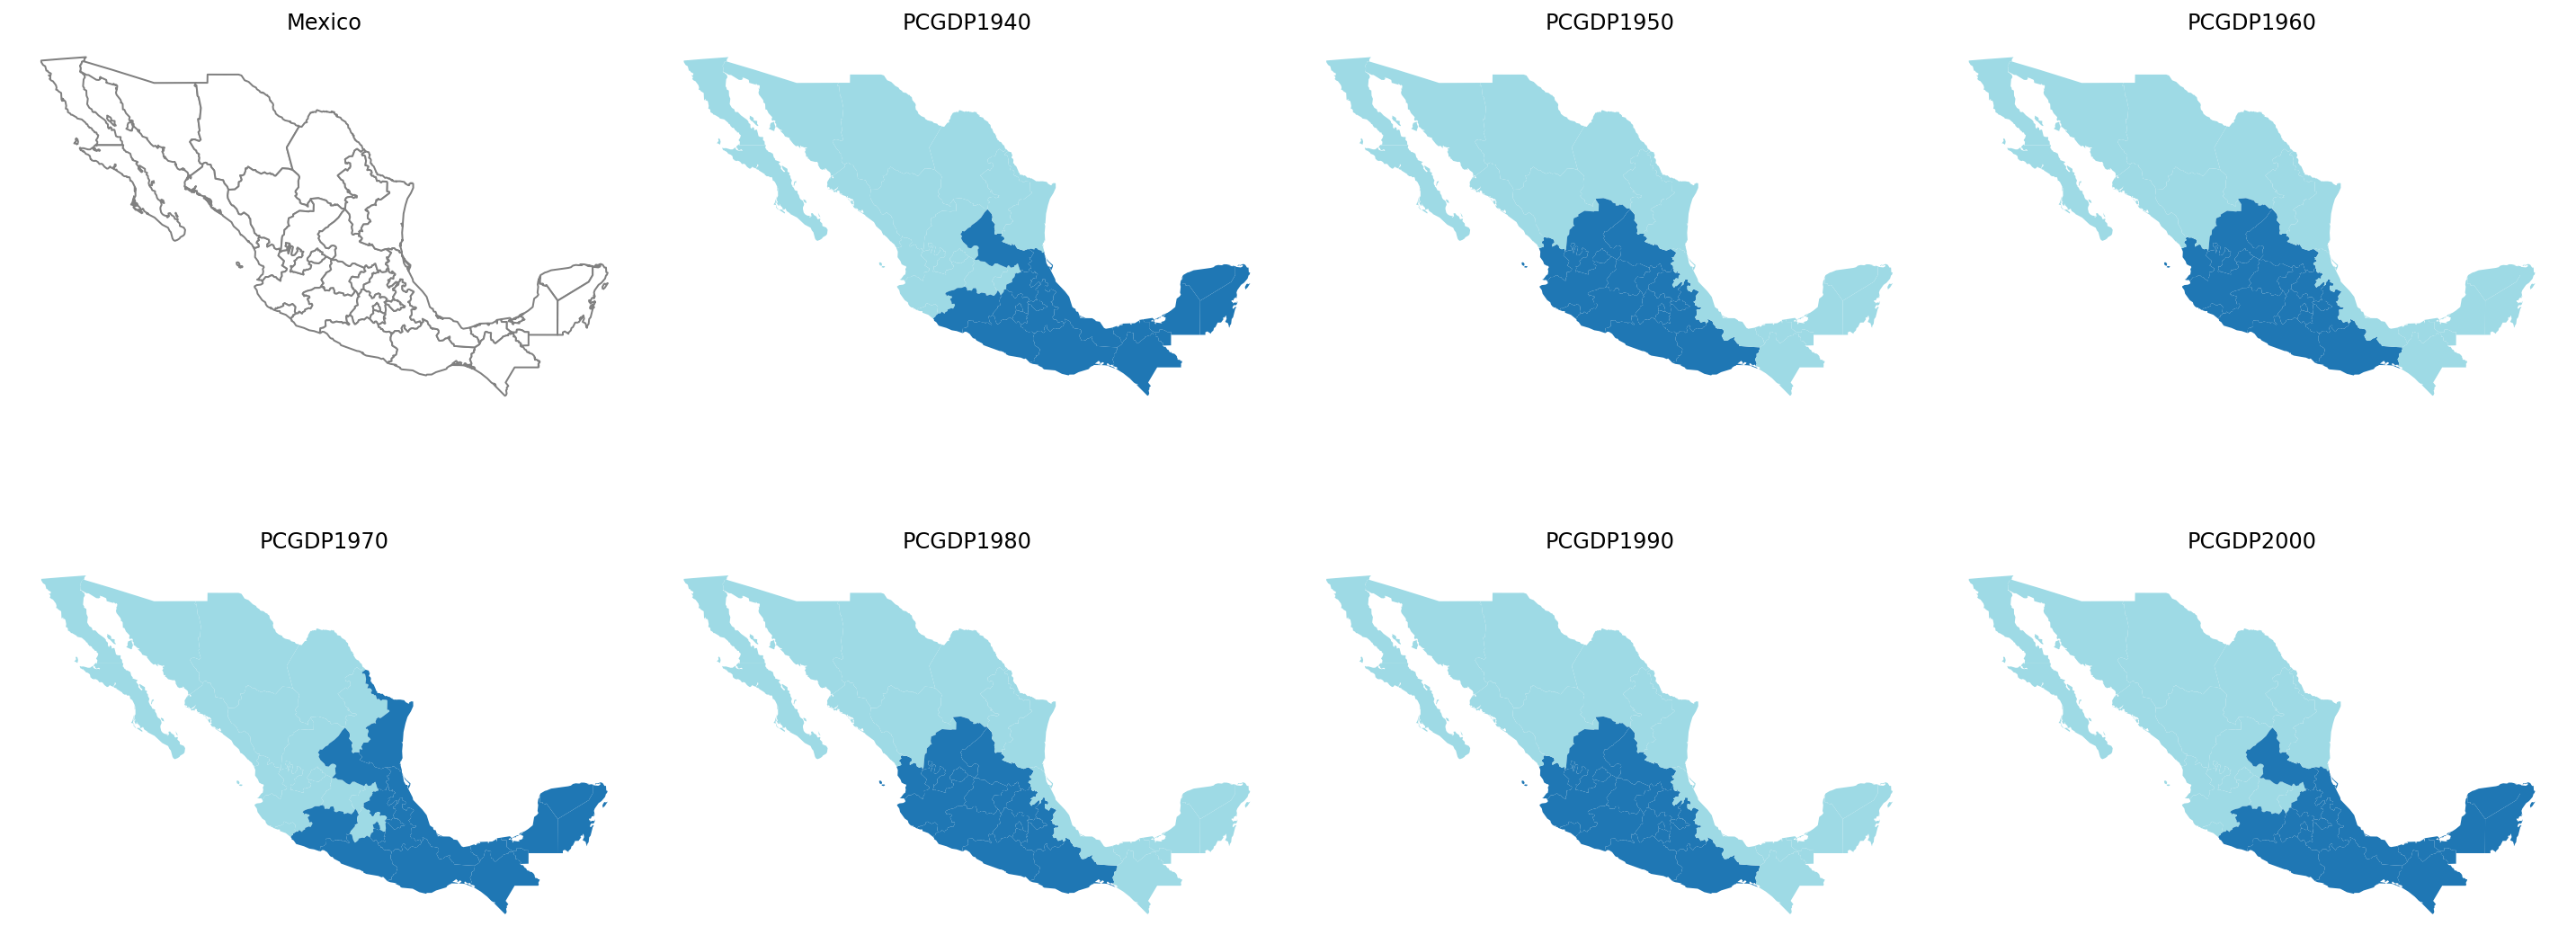

In [22]:
subplotter(mexico, mxgdp_years.reshape(2,4), w, threshold=15, top_n=2)

####  Vary state enclave assignments (1, 3, 5); hold minimum in-region threshold constant (5)

**1 state**

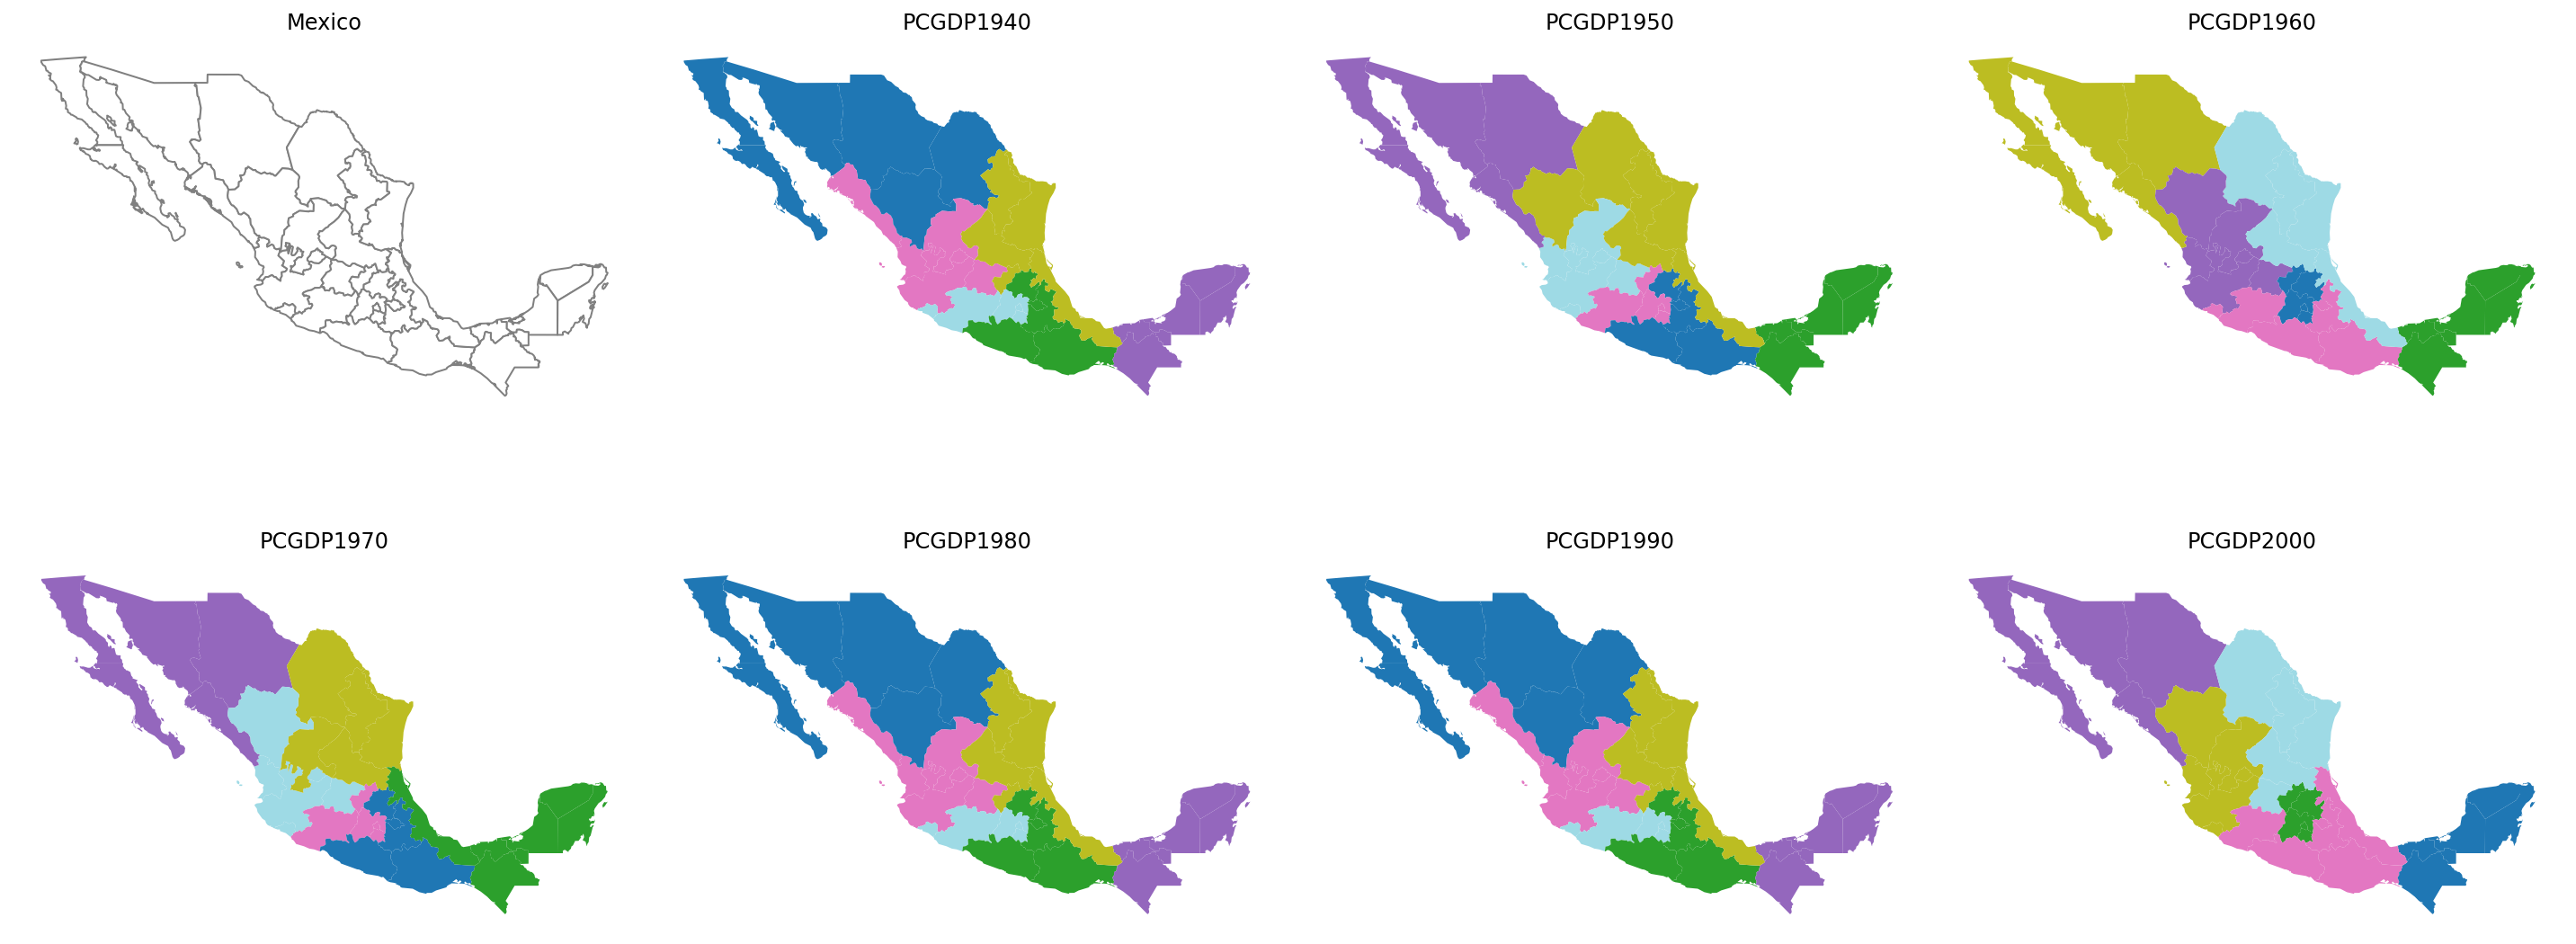

In [23]:
subplotter(mexico, mxgdp_years.reshape(2,4), w, threshold=5, top_n=1)

**3 states**

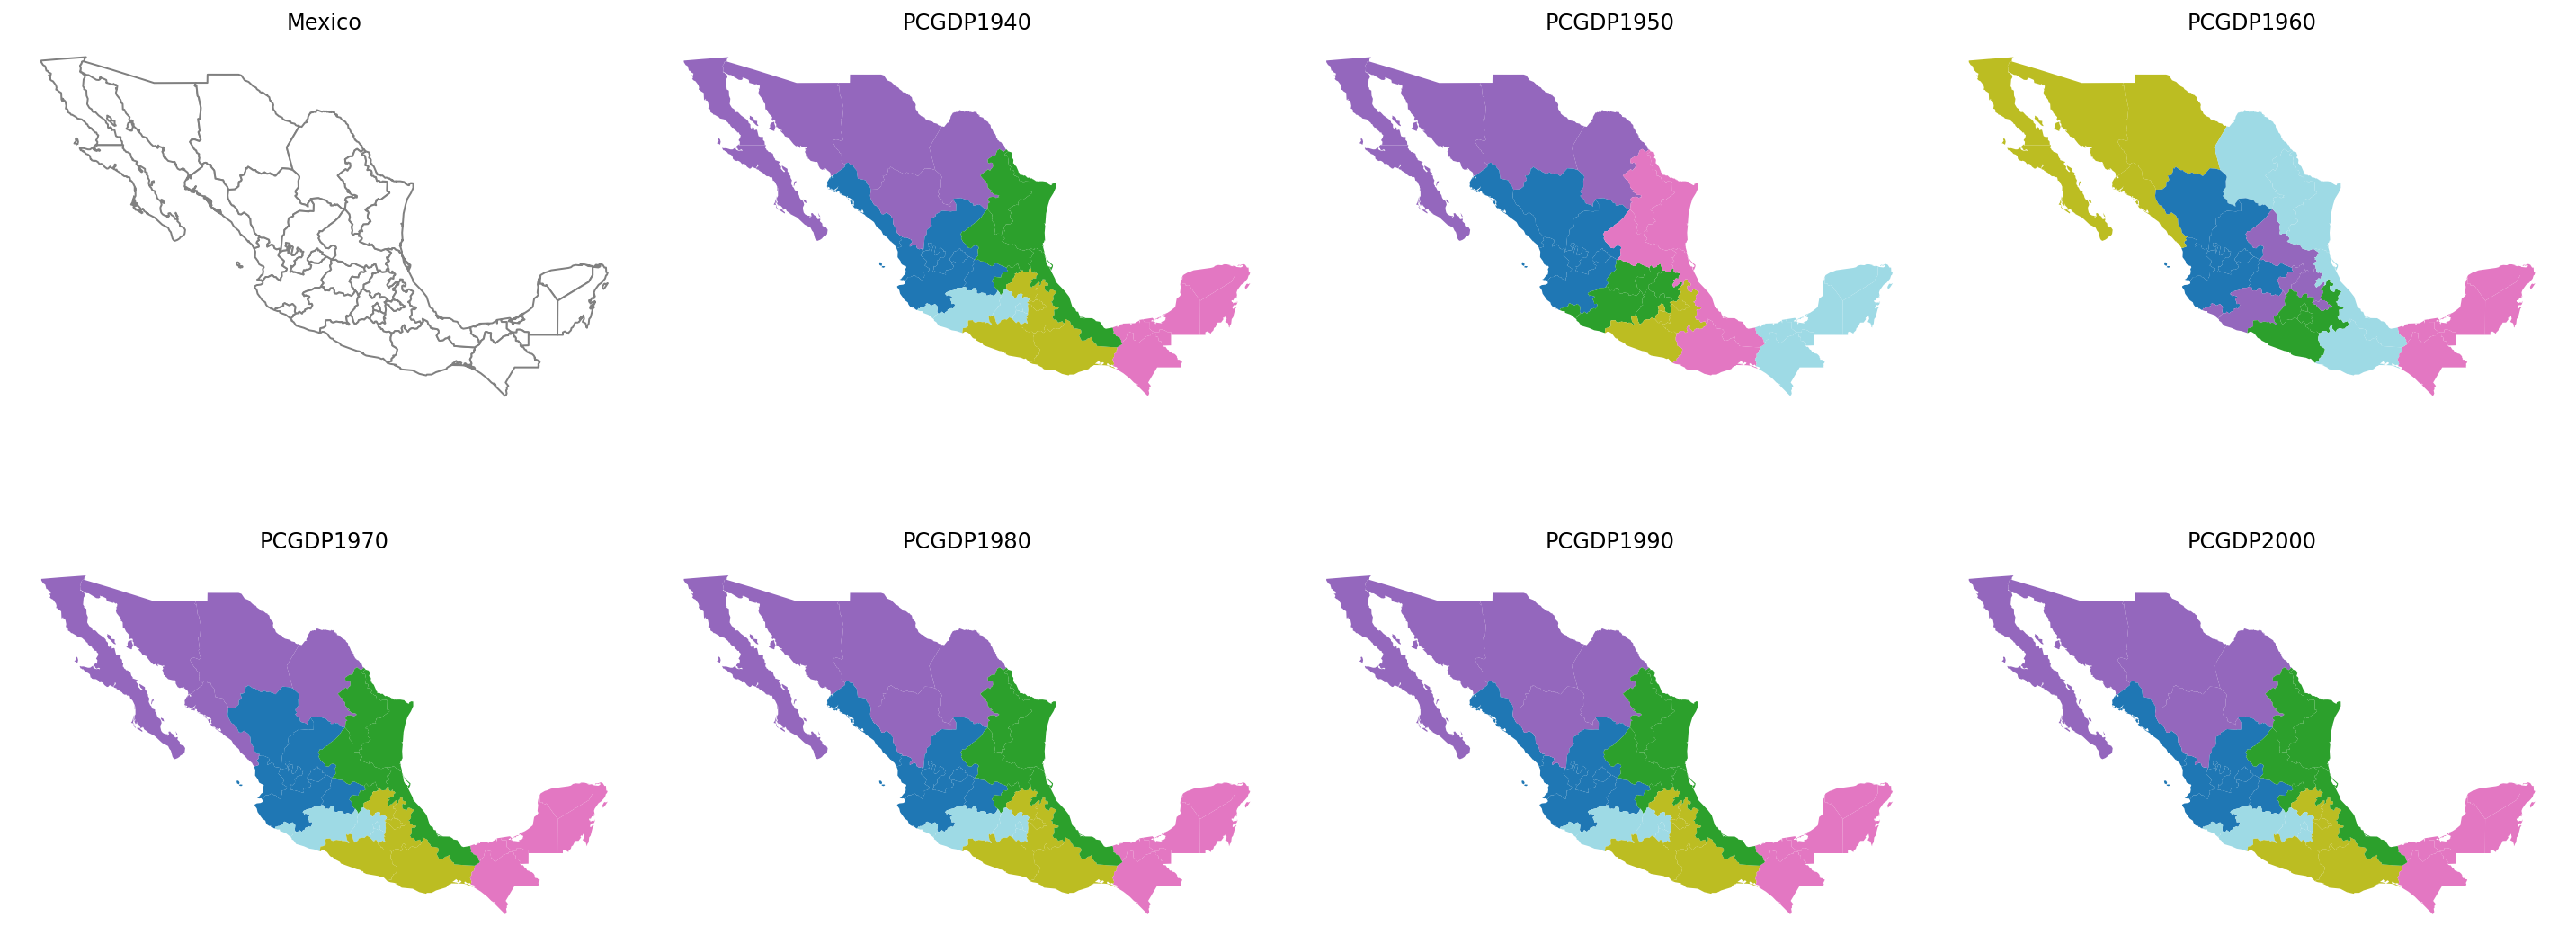

In [24]:
subplotter(mexico, mxgdp_years.reshape(2,4), w, threshold=5, top_n=3)

**5 states**

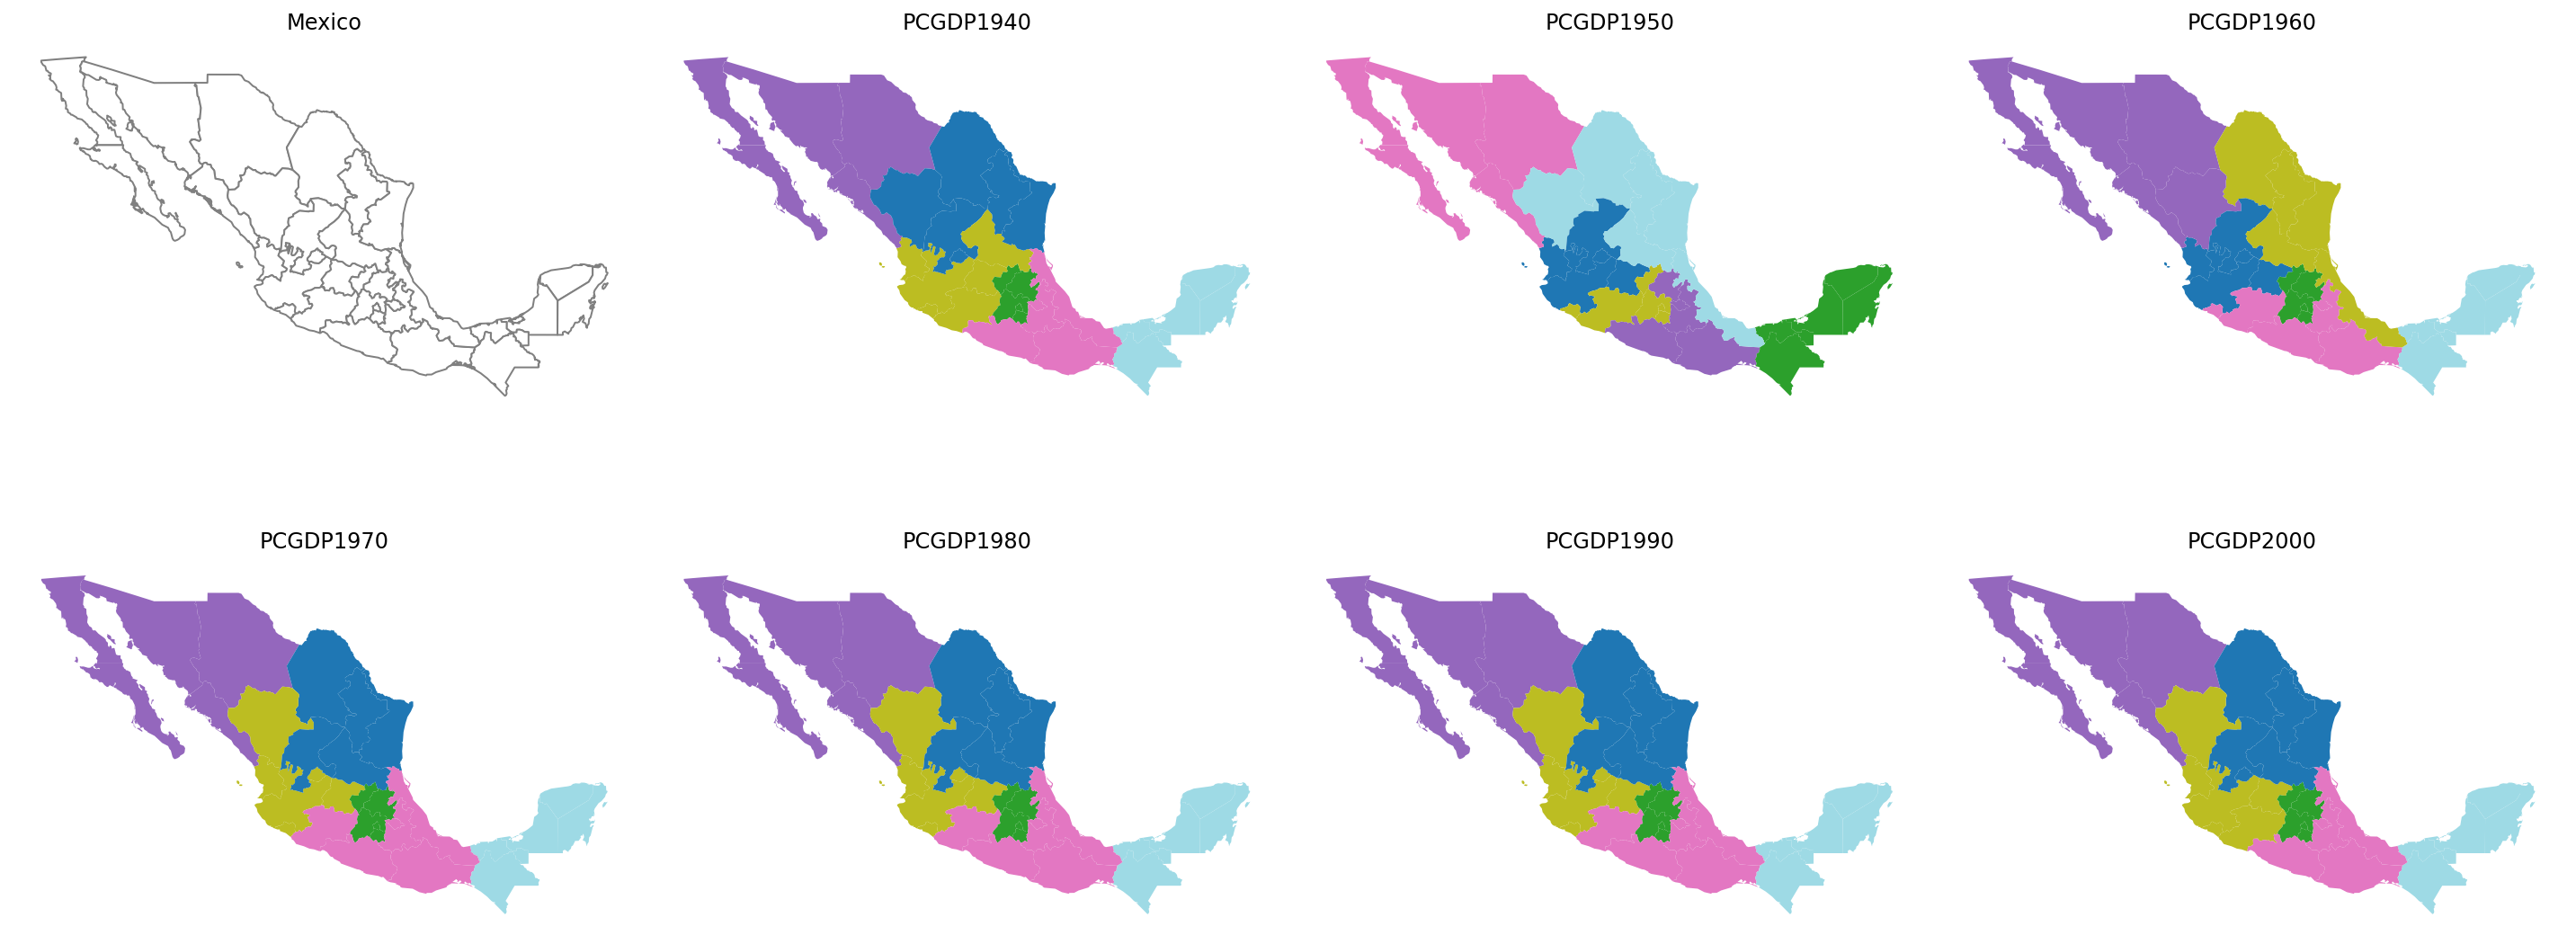

In [25]:
subplotter(mexico, mxgdp_years.reshape(2,4), w, threshold=5, top_n=5)

As shown here, varying the `threshold` and `top_n` parameters both have a demonstrable effect regionalization outcomes.

-------------------